In [139]:
import os
import openai
import math, random
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from dataclasses import dataclass

load_dotenv()

True

In [140]:
# let's create some classes that make managing prompts easier
@dataclass
class Solution:
    solution_name: str  # the name of the solution, e.g. "trace"
    solution_text: str  # the text solution to a problem
    value_name: str  # the name of the value used to measure the solution, e.g. "length" or "score"
    value: int  # the value of the solution, e.g. 5 or 10


class MathPrompt:
    def __init__(
        self,
        problem: str,  # text description of the problem to be solved
        instruction: str,  # instructions on what type of solution to provide and in what format
        solution_description: str,  # a description of the solutions and how they are ordered (e.g., "arranged in descending order based on their lengths, where lower values are better")
        solution_count: int = 5,  # the maximum number of solutions to include in the prompt string
        sort_ascending: bool = True,  # whether the solutions are sorted in ascending or descending order
    ):
        self.problem = problem
        self.solution_description = solution_description
        self.solutions = []
        self.instruction = instruction
        self.prompt_string = ""
        self.solution_count = solution_count
        self.sort_ascending = sort_ascending
        self.ordered_values = [] # the values of the solutions in the order they are determined by the model

    def update_prompt_string(self):
        """
        Creates a string representation of the prompt that can be used to display the prompt to the user or provide it to a language model.
        """
        solutions_string = "\n\n".join(
            f"{solution.solution_name}: {solution.solution_text}\n{solution.value_name}: {solution.value}"
            for solution in self.solutions
        )

        # only include the last solution_count solutions
        solutions_string = "\n\n".join(
            solutions_string.split("\n\n")[-self.solution_count:]
        )

        self.prompt_string = f"{self.problem}\n\n{self.solution_description}\n\n{solutions_string}\n\n{self.instruction}"

    def add_solution(self, solution: Solution):
        """
        Adds a solution to the list of solutions, sorts the list by value in ascending order, and updates the prompt string.
        """
        self.solutions.append(solution)

        self.ordered_values.append(solution.value)

        # sort the solutions by value in ascending order
        self.solutions.sort(key=lambda solution: solution.value, reverse=not self.sort_ascending)

        self.update_prompt_string()

    def __repr__(self):
        return self.prompt_string


In [141]:
# ok, let's test out the class with an example from Figure 18 the paper
problem = "You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58)."
solution_description = "Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better."
instruction = "Give me a new trace that is different from all traces above, and has a length lower than any of the above. The trace should traverse all points exactly once. The trace should start with <trace> and end with </trace>."

solutions = []
solutions.append(Solution(
    "trace",
    "<trace> 0,13,3,16,19,2,17,5,4,7,18,8,1,9,6,14,11,15,10,12 </trace>",
    "length",
    2254,
))
solutions.append(Solution(
    "trace",
    "<trace> 0,4,18,11,9,7,14,17,12,5,10,15,19,3,13,16,1,6,8,2 </trace>",
    "length",
    2017,
))
solutions.append(Solution(
    "trace",
    "<trace> 9,11,4,13,6,10,8,17,12,15,3,5,19,2,1,18,14,7,16,0 </trace>",
    "length",
    1953,
))
solutions.append(Solution(
    "trace",
    "<trace> 2,18,11,4,9,7,14,12,17,15,5,10,19,3,13,16,1,6,8,0 </trace>",
    "length",
    2017,
))
solutions.append(Solution(
    "trace",
    "<trace> 11,0,4,13,6,10,8,17,12,3,15,5,19,2,1,18,14,7,16,9 </trace>",
    "length",
    1953,
))

test_problem = MathPrompt(problem, instruction, solution_description, solution_count=4, sort_ascending=False)

for solution in solutions:
    test_problem.add_solution(solution)

print(test_problem) # should only show two solutions in the prompt

print(f"\n\nThere are actually {len(test_problem.solutions)} solutions in the problem's structure.")

You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58).

Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better.

trace: <trace> 0,4,18,11,9,7,14,17,12,5,10,15,19,3,13,16,1,6,8,2 </trace>
length: 2017

trace: <trace> 2,18,11,4,9,7,14,12,17,15,5,10,19,3,13,16,1,6,8,0 </trace>
length: 2017

trace: <trace> 9,11,4,13,6,10,8,17,12,15,3,5,19,2,1,18,14,7,16,0 </trace>
length: 1953

trace: <trace> 11,0,4,13,6,10,8,17,12,3,15,5,19,2,1,18,14,7,16,9 </trace>
length: 1953

Give me a new trace that is different from all traces above, and has a length lower than any of the above. The trace should

In [142]:
# ok, that matches the example from the paper pretty well. now we need a quick utility function to calculate the total distance covered in a trace
points = [
        (-4, 5),
        (17, 76),
        (-9, 0),
        (-31, -86),
        (53, -35),
        (26, 91),
        (65, -33),
        (26, 86),
        (-13, -70),
        (13, 79),
        (-73, -86),
        (-45, 93),
        (74, 24),
        (67, -42),
        (87, 51),
        (83, 94),
        (-7, 52),
        (-89, 47),
        (0, -38),
        (61, 58),
    ]

def calculate_trace_length(points: list, trace: str):
    """
    Calculates the total distance covered in a trace. Assumes that the trace is a string of comma-separated integers, where each integer represents a point.
    """
    # remove <trace> and </trace> tags in case they were provided, and remove any leading / trailing whitespace
    trace = trace.replace("<trace>", "").replace("</trace>", "").strip()

    # if the trace consists of anything other than comma-separated integers, return inf and let the user know that the trace is invalid
    if not all(char.isdigit() or char == "," for char in trace):
        print("The trace should consist of comma-separated integers.")
        return math.inf

    # if the wrong number of points were chosen, return inf and let the user know that the trace is invalid
    if len(trace.split(",")) != len(points):
        print(f"Expected {len(points)} points in the trace, but {len(trace.split(','))} were found.")
        return math.inf
    
    # if any points were missed, return inf and let the user know that the trace is invalid
    for i in range(len(points)):
        if str(i) not in trace:
            print(f"Point {i} was not visited in the trace.")
            return math.inf

    chosen_points = [points[int(point)] for point in trace.split(",")]
    
    total_distance = 0

    for i in range(len(chosen_points) - 1):
        total_distance += math.dist(chosen_points[i], chosen_points[i + 1])

    # round to the nearest integer
    return round(total_distance)

# let's make another utility function that generates some random solutions
def generate_random_solutions(points: list, num_solutions: int = 5):
    solutions = []

    for i in range(num_solutions): 
        random_ordering = list(range(len(points)))  # convert range to list
        random.shuffle(random_ordering)  # shuffle the list in-place
        trace = f"<trace> {','.join(map(str, random_ordering))} </trace>"  # convert integers to strings before joining
        solutions.append(Solution("trace", trace, "length", calculate_trace_length(points, trace)))

    return solutions

In [143]:
# let's make sure this works
print(calculate_trace_length(points, "<trace> 0,13,3,16,19,2,17,5,4,7,18,8,1,9,6,14,11,15,10,12 </trace>")) # should be 2254
print(calculate_trace_length(points, "<trace> 0,18,4,11,9,7,14,17,12,15,10,5,19,3,13,16,1,6,8,2 </trace>")) # should be 2017

# and let's print some random solutions
print(f"\nRandom solutions:")
for solution in generate_random_solutions(points):
    print(solution)

2174
2010

Random solutions:
Solution(solution_name='trace', solution_text='<trace> 16,7,13,17,6,15,9,2,12,0,4,5,11,8,19,3,18,14,10,1 </trace>', value_name='length', value=2315)
Solution(solution_name='trace', solution_text='<trace> 18,12,7,3,14,4,6,16,17,1,5,9,19,0,2,8,15,13,10,11 </trace>', value_name='length', value=1849)
Solution(solution_name='trace', solution_text='<trace> 9,12,2,7,13,3,14,10,1,15,19,0,18,8,5,16,17,11,4,6 </trace>', value_name='length', value=1888)
Solution(solution_name='trace', solution_text='<trace> 17,1,9,16,19,2,8,18,5,7,3,4,11,12,15,0,10,6,14,13 </trace>', value_name='length', value=1766)
Solution(solution_name='trace', solution_text='<trace> 14,11,9,3,7,18,8,2,5,15,19,6,12,0,13,16,1,10,17,4 </trace>', value_name='length', value=1929)


In [144]:
# ok, those were close enough; now let's start working on feeding the problems to a model
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_new_trace(prompt: str):
  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system", "content": "You are a helpful assistant who helps users solve math problems You respond ONLY with the answer in the format the user directs."},
      {"role": "user", "content": prompt},
    ]
  )

  return completion.choices[0].message.content



In [145]:
# let's test it out!
get_new_trace(test_problem.prompt_string)

'<trace> 15, 12, 5, 3, 19, 16, 0, 4, 13, 6, 10, 8, 17, 11, 9, 7, 14, 18, 1, 2 </trace>'

In [146]:
# now let's put it all together and try to get 3.5-turbo to solve the problem!
starting_solutions = generate_random_solutions(points, num_solutions=3)
problem = MathPrompt(problem, instruction, solution_description, solution_count=10, sort_ascending=False)

for solution in starting_solutions:
    problem.add_solution(solution)

print(problem)



You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58).

Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better.

trace: <trace> 10,3,18,15,16,14,11,6,5,2,7,1,0,17,8,12,19,13,4,9 </trace>
length: 1797

trace: <trace> 16,14,5,15,11,8,4,1,17,7,0,2,3,10,9,18,13,6,12,19 </trace>
length: 1639

trace: <trace> 8,18,0,17,2,4,16,11,5,7,15,10,3,13,12,1,9,14,6,19 </trace>
length: 1425

Give me a new trace that is different from all traces above, and has a length lower than any of the above. The trace should traverse all points exactly once. The trace should start with <trace> and end with </tr

In [147]:
def solve_traveling_salesman(problem: MathPrompt, max_iters: int = 20, batch_size: int = 4):
    """
    Solves a traveling salesman problem using GPT-3.5-turbo.

    Args:
    - problem: a MathPrompt object
    - max_iters: the maximum number of iterations to run
    - batch_size: the number of solutions to generate per iteration
    """
    no_improvement_counter = 0
    failure_counter = 0
    api_count = 0
    for i in range(max_iters):
        solutions = []
        for j in range(batch_size):
            new_trace = get_new_trace(problem.prompt_string)
            new_length = calculate_trace_length(points, new_trace)

            if problem.sort_ascending:
                if new_length < problem.solutions[0].value:
                    no_improvement_counter += 1
            else:
                if new_length > problem.solutions[0].value:
                    no_improvement_counter += 1
            api_count += 1

            # if inf or -inf, then count a failure
            if new_length == math.inf or new_length == -math.inf:
                failure_counter += 1
            else:
                solutions.append(Solution("trace", new_trace, "length", new_length))

        for solution in solutions: # add all solutions from a batch at once
            problem.add_solution(solution)

        if no_improvement_counter > max_iters * batch_size / 3:
            print(f"Stopping early after {i} iterations without improvement.")
            print(f"There were {failure_counter} failures out of {api_count} API calls.")
            break

    print(f"There were {failure_counter} failures out of {api_count} API calls.")
    return problem


In [148]:
solve_traveling_salesman(problem, max_iters=20)


The trace should consist of comma-separated integers.
Expected 20 points in the trace, but 21 were found.
The trace should consist of comma-separated integers.
The trace should consist of comma-separated integers.
The trace should consist of comma-separated integers.
Point 16 was not visited in the trace.
The trace should consist of comma-separated integers.
The trace should consist of comma-separated integers.
The trace should consist of comma-separated integers.
Expected 20 points in the trace, but 21 were found.
The trace should consist of comma-separated integers.
Expected 20 points in the trace, but 21 were found.
Expected 20 points in the trace, but 21 were found.
Expected 20 points in the trace, but 40 were found.
Expected 20 points in the trace, but 21 were found.
Expected 20 points in the trace, but 21 were found.
Expected 20 points in the trace, but 34 were found.
Expected 20 points in the trace, but 21 were found.
Expected 20 points in the trace, but 21 were found.
Expected 

You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58).

Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better.

trace: <trace> 8,18,0,17,2,4,16,11,5,7,15,10,3,13,6,12,1,9,14,19 </trace>
length: 1274

trace: <trace> 8,18,0,17,2,4,16,11,5,7,15,10,3,13,6,12,1,9,14,19 </trace>
length: 1274

trace: <trace> 8,18,0,17,2,4,16,11,5,7,15,10,3,13,6,12,19,9,1,14 </trace>
length: 1254

trace: <trace> 8,18,0,17,2,4,16,11,5,7,15,10,3,13,6,12,19,9,1,14 </trace>
length: 1254

trace: <trace> 8,18,0,17,2,4,16,11,5,7,15,10,3,13,6,12,1,9,19,14 </trace>
length: 1248

trace: <trace> 8,18,0,17,2,4,16,11,

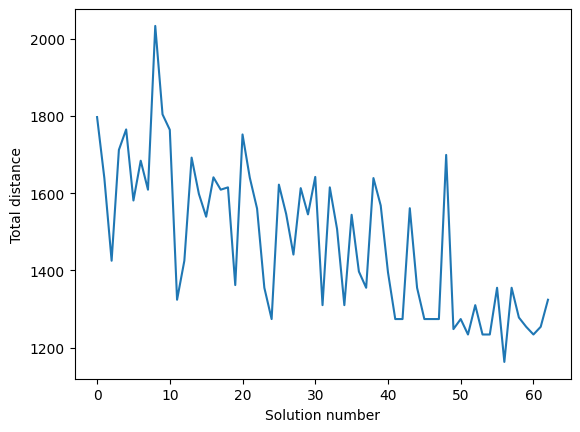

In [149]:
# now let's plot the results; if the model is able to optimize, we would expect that problem.ordered_values trends downward
# if it can't, the results should be random
plt.plot(problem.ordered_values)
plt.ylabel('Total distance')
plt.xlabel('Solution number')
plt.show()